# Instacart Exploratory Analysis

### Data Description: 

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

### Database Info & Import Data

Here are the db tables and columns: 

aisles:
   aisle_id, aisle   
departments:
    department_id, department  
order_products__prior***:
    order_id, product_id, add_to_cart_order, reordered
order_products__train:
    order_id, product_id, add_to_cart_order, reordered 
orders***:
    order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products:
    product_id, product_name, aisle_id, department_id
sample_submission:
    order_id, products

order_products__prior:
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

orders:
This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

In [3]:
#database connection
conn = sqlite3.connect("Instacart.db")

query1 = "select * from order_products__train;"
order_products_train = pd.read_sql_query(query1, conn)

query2 = "select * from order_products__prior;"
order_products_prior = pd.read_sql_query(query2, conn)

query3 = "select * from orders;"
orders = pd.read_sql_query(query3, conn)

query4 = "select * from products;"
products = pd.read_sql_query(query4, conn)

query5 = "select * from aisles;"
aisles = pd.read_sql_query(query5, conn)

query6 = "select * from departments;"
departments = pd.read_sql_query(query6, conn)

conn.close()

### Data Analysis

In [5]:
# concat order_products_prior & order_products_train since they have the same columns
all_orders = pd.concat([order_products_prior, order_products_train])
all_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [65]:
all_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 1.3 GB


In [67]:
all_orders.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Let's look at the total number of items in an order

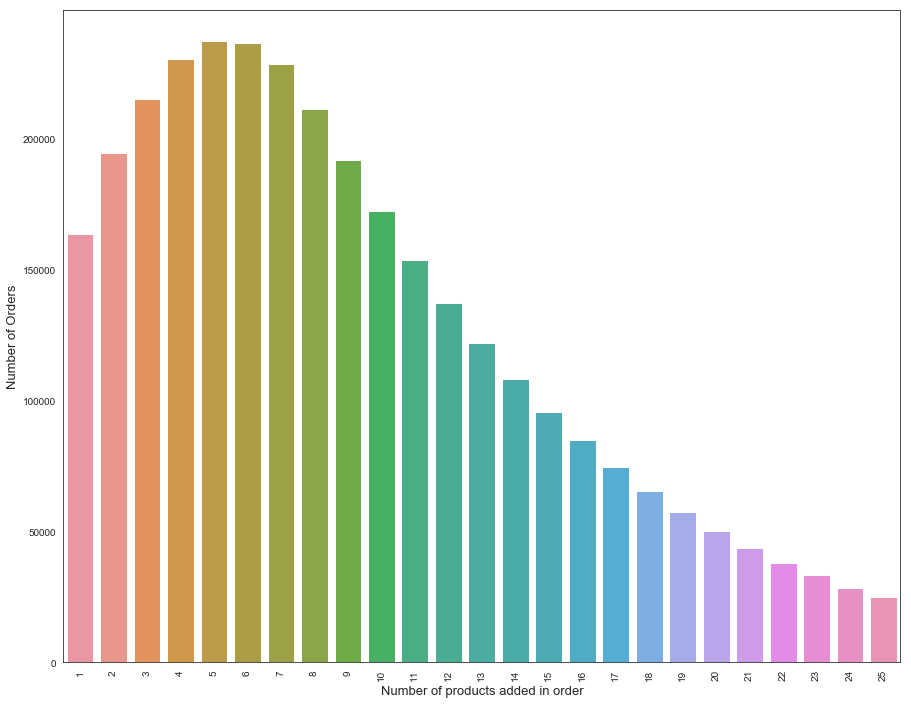

In [90]:
# grab the max of add_to_cart_order, after grouping by order_id
# max because we want all the products that were in a given order
grouped = all_orders.groupby("order_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = grouped.Total_reorders.value_counts()[:25]

sns.set_style('white')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

Looks like most orders have 5-6 items 

### Now let's look at what products people are purchasing most often

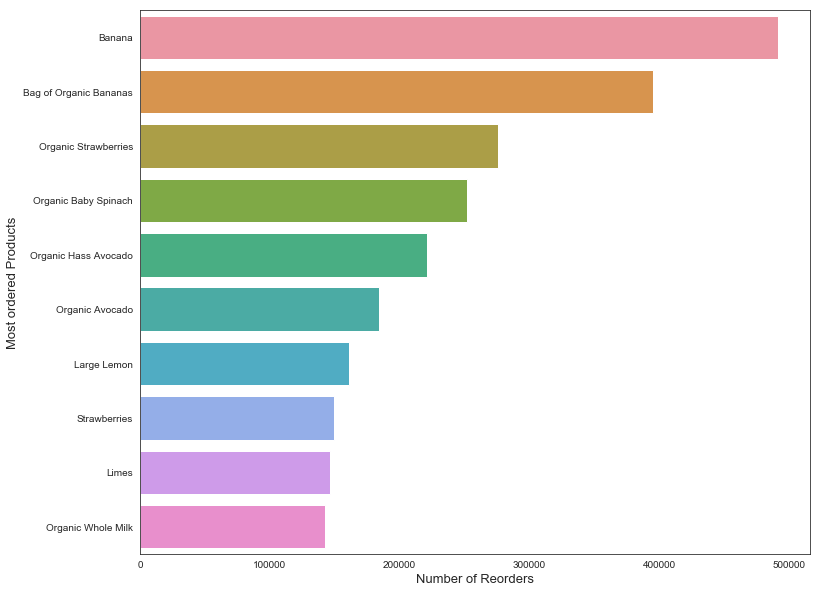

In [144]:
# group by product_id, find find values for reordered, create column that counts the total reorders
grouped = all_orders.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()

# merge the grouped_df and products_df so we can get the product names. Left join on Product ID
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])

# sort values in descending order, display top 10 items
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]

# group by product name, sum total reorders
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

# plot top 10 items
sns.set_style('white')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(grouped.values, grouped.index)
plt.xlabel('Number of Reorders', fontsize=13)
plt.ylabel('Most ordered Products', fontsize=13)
plt.show()

People really like their bananas :) 

### Which products are most likely to be reordered? 

In [148]:
# group by product_id, aggregating by reordered
grouped = all_orders.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()

# create reorder probability column
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']

# merge df with products for more info
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])

# with more than 100 orders, what are the top 10 products least likely to be reordered
grouped = grouped[grouped.reorder_total > 100].sort_values(['reorder_probability'], ascending=False)[:10]

# view top 10 
grouped[:10]

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized
45501,45504,8091,9410,0.859830,Whole Organic Omega 3 Milk
17466,17469,416,484,0.859504,Lo-Carb Energy Drink
43391,43394,7511,8742,0.859186,Organic Lactose Free Whole Milk


I guess people like their chocolate and chadonnay 

### Which products are least likely to be reordered? 

In [93]:
# with more than 100 orders, what are the top 10 products least likely to be reordered
grouped = grouped[grouped.reorder_total > 100].sort_values(['reorder_probability'], ascending=True)

# view data
grouped[:10]

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
11669,11672,1,214,0.004673,Ground Sage
10373,10376,1,142,0.007042,Organic Caraway Seeds
20427,20430,1,106,0.009434,Organic Whole Nutmeg
24361,24364,2,178,0.011236,Organic Chinese Five Spice
13370,13373,2,132,0.015152,Food Coloring
29008,29011,2,126,0.015873,Rubbed Sage
30028,30031,2,106,0.018868,Cajun Street Seasoning
32653,32656,3,153,0.019608,Garam Masala
6501,6503,3,148,0.020270,Ground Coriander Seed
48515,48519,3,142,0.021127,Green Food Color


This makes sense. You often use spices, however not enough to have them reordered frequently

### Now let's look at Time of Day and Day of Week

In [94]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


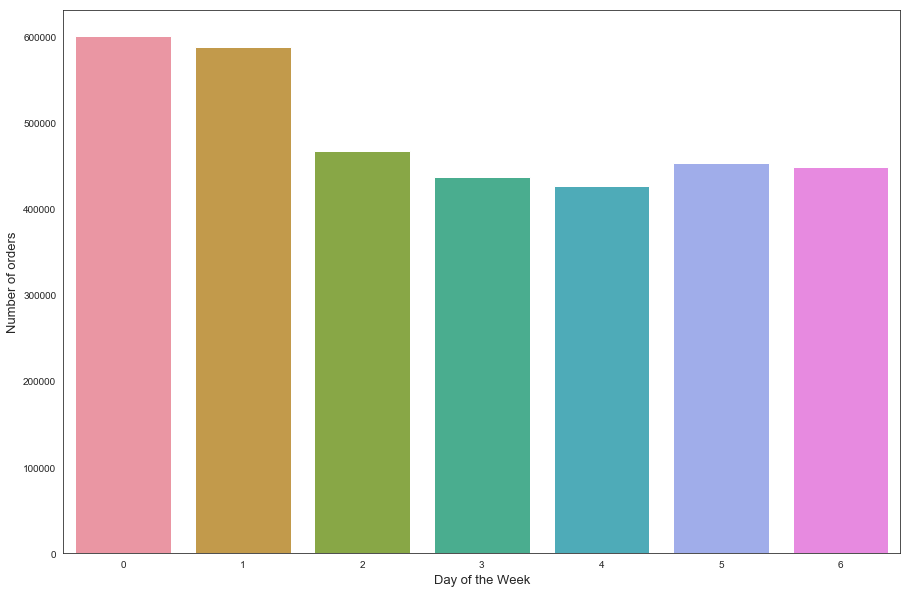

In [104]:
# group by order_id since the order_id was generated at the time of order
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()

# grab the values only
grouped = grouped.order_dow.value_counts()

# plot 
sns.set_style('white')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Day of the Week', fontsize=13)
plt.show()

Looks like the days of the week are anonimyzed, so we don't know which day is which. 

### Days Since Reorder Distribution

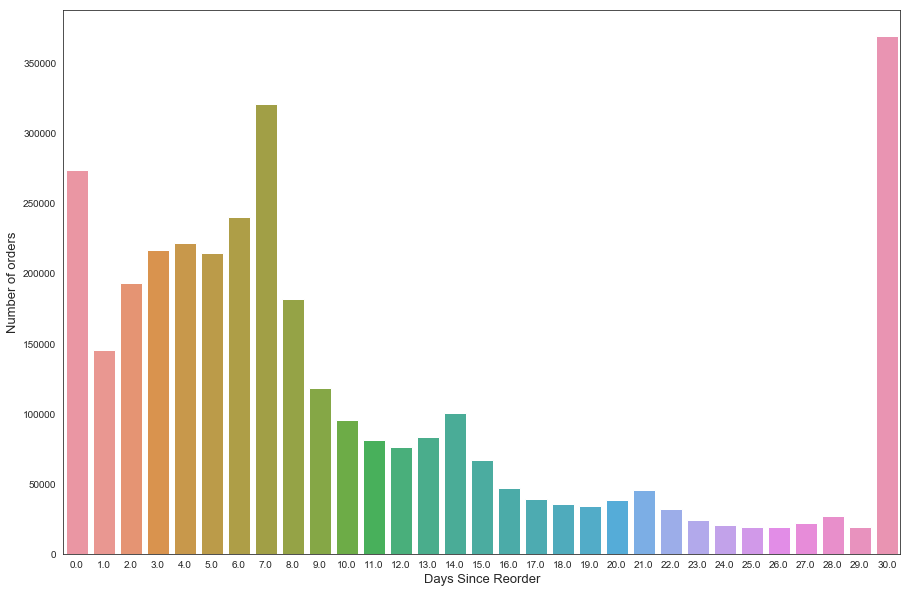

In [107]:
# group by order_id since the order_id was generated at the time of order
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()

# grab the values only
grouped = grouped.days_since_prior_order.value_counts()

# plot 
sns.set_style('white')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days Since Reorder', fontsize=13)
plt.show()

A large portion of users order 1 month later. This makes sense if there are recurring, monthly subecriptions. Same thing with 7 if there are recurring, weekly subscriptions. What's interesting here is reorders after 0 days. Not sure if this means people are ordering multiple products in the same day? We can probably ignore.

### Let's move onto aisles & departments

In [108]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
# groupby product_id, create column for sum of reorders, create column for total sum of orders
grouped = all_orders.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()

# create a probability column --> Total reorders / Total Orders
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']

# merge products column with grouped to get product id for later merging
grouped = pd.merge(grouped, products[['product_id', 'product_name', 'aisle_id', 'department_id']], how='left', on=['product_id'])

# merge aisles column with grouped to get aisle names
grouped = pd.merge(grouped, aisles[['aisle_id', 'aisle']], how='left', on=['aisle_id'])

# merge departments column with grouped to get departments names
grouped = pd.merge(grouped, departments[['department_id', 'department']], how='left', on=['department_id'])

#### Aisles most likely to have reorders

In [169]:
# group by reorder probability
grouped_desc = grouped.sort_values(['reorder_probability'], ascending=False)

# create new df with aisles only
aisles_grouped = grouped_desc[['aisle', 'reorder_probability']].copy()

# view data
aisles_grouped[:10]

,aisle,reorder_probability
6431,prepared meals,0.942029
2074,feminine care,0.933333
43550,energy sports drinks,0.923077
27737,candy chocolate,0.921569
14606,baby food formula,0.914286
13872,other,0.911111
39989,energy sports drinks,0.909091
5866,red wines,0.900000
36540,spreads,0.898551
26090,chips pretzels,0.895522


Aisles with the highest probability of reorder are prepared foods, feminie care, and energy sports drinks. That's interesting because I would have assumed candy chocolate would be higher than 4th on the list. 

#### Aisles least likely to have reorders

In [170]:
# group by reorder probability
grouped_asc = grouped.sort_values(['reorder_probability'], ascending=True)

# create new df with aisles only
aisles_grouped = grouped_asc[['aisle', 'reorder_probability']].copy()

# view data
aisles_grouped[:10]

,aisle,reorder_probability
5317,baking ingredients,0.0
5284,vitamins supplements,0.0
30099,candy chocolate,0.0
5279,laundry,0.0
30112,soup broth bouillon,0.0
11589,kosher foods,0.0
5271,baking ingredients,0.0
30136,hot dogs bacon sausage,0.0
30138,bakery desserts,0.0
30093,kitchen supplies,0.0


#### Departments most likely to have reorders

In [171]:
# create new df with departments only
departments_grouped = grouped_desc[['department', 'reorder_probability']].copy()

# view data
departments_grouped[:10]

,department,reorder_probability
6431,deli,0.942029
2074,personal care,0.933333
43550,beverages,0.923077
27737,snacks,0.921569
14606,babies,0.914286
13872,other,0.911111
39989,beverages,0.909091
5866,alcohol,0.900000
36540,pantry,0.898551
26090,snacks,0.895522


Departments with the highest reorder probability are deli, personal care, and beverages. These should be no surprise after seeing the top aisles listed above.  

#### Departments least likely to have reorders

In [172]:
# create new df with departments only
departments_grouped = grouped_asc[['department', 'reorder_probability']].copy()

# view data
departments_grouped[:10]

,department,reorder_probability
5317,pantry,0.0
5284,personal care,0.0
30099,snacks,0.0
5279,household,0.0
30112,canned goods,0.0
11589,international,0.0
5271,pantry,0.0
30136,meat seafood,0.0
30138,bakery,0.0
30093,household,0.0


#### Departments by Order Volume

In [173]:
grouped.head()

,product_id,reorder_sum,reorder_total,reorder_probability,product_name,aisle_id,department_id,aisle,department
0,1,1185,1928,0.614627,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,13,94,0.138298,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,209,283,0.738516,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,161,351,0.458689,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,10,16,0.625000,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


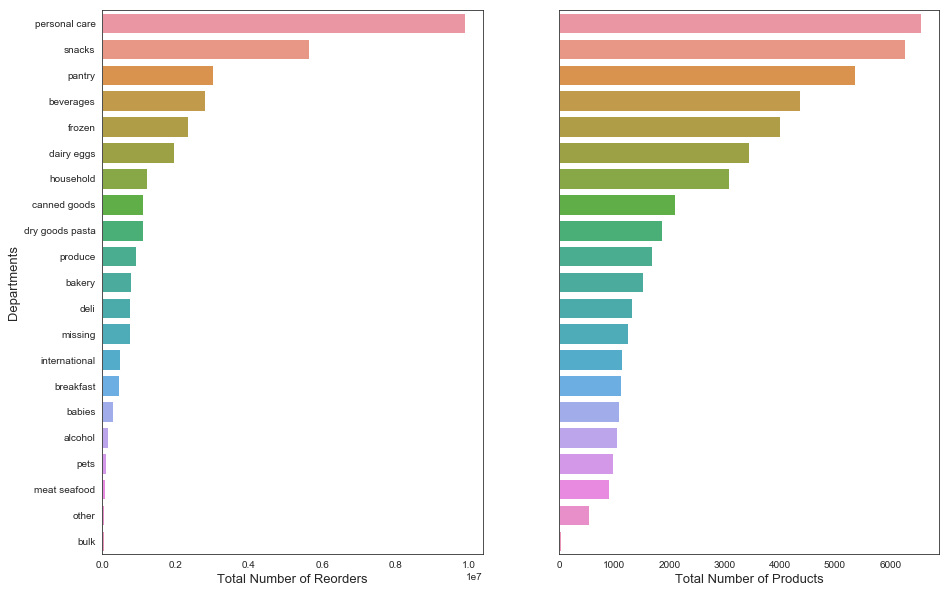

In [197]:
# create new df with departments only by count of reorders
departments_reorders = grouped.groupby(['department']).sum()['reorder_total'].sort_values(ascending=False)

# create new df with departments only by count of products
departments_products = grouped.groupby(['department']).count()['product_id'].sort_values(ascending=False)

# plot data
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
plt.xticks(rotation='horizontal')
sns.barplot(departments_reorders.values, departments_reorders.index, ax=ax1)
sns.barplot(departments_products.values, departments_products.index, ax=ax2)
ax1.set_xlabel('Total Number of Reorders', fontsize=13)
ax1.set_ylabel('Departments', fontsize=13)
ax2.set_xlabel('Total Number of Products', fontsize=13)
ax2.set_ylabel(' ')
plt.show()

Personal Care has the highest number of reorders aas well as the highest number of products. The number of products within a department appears to be related to the number of reorders. 

### Most Important Aisles by Department

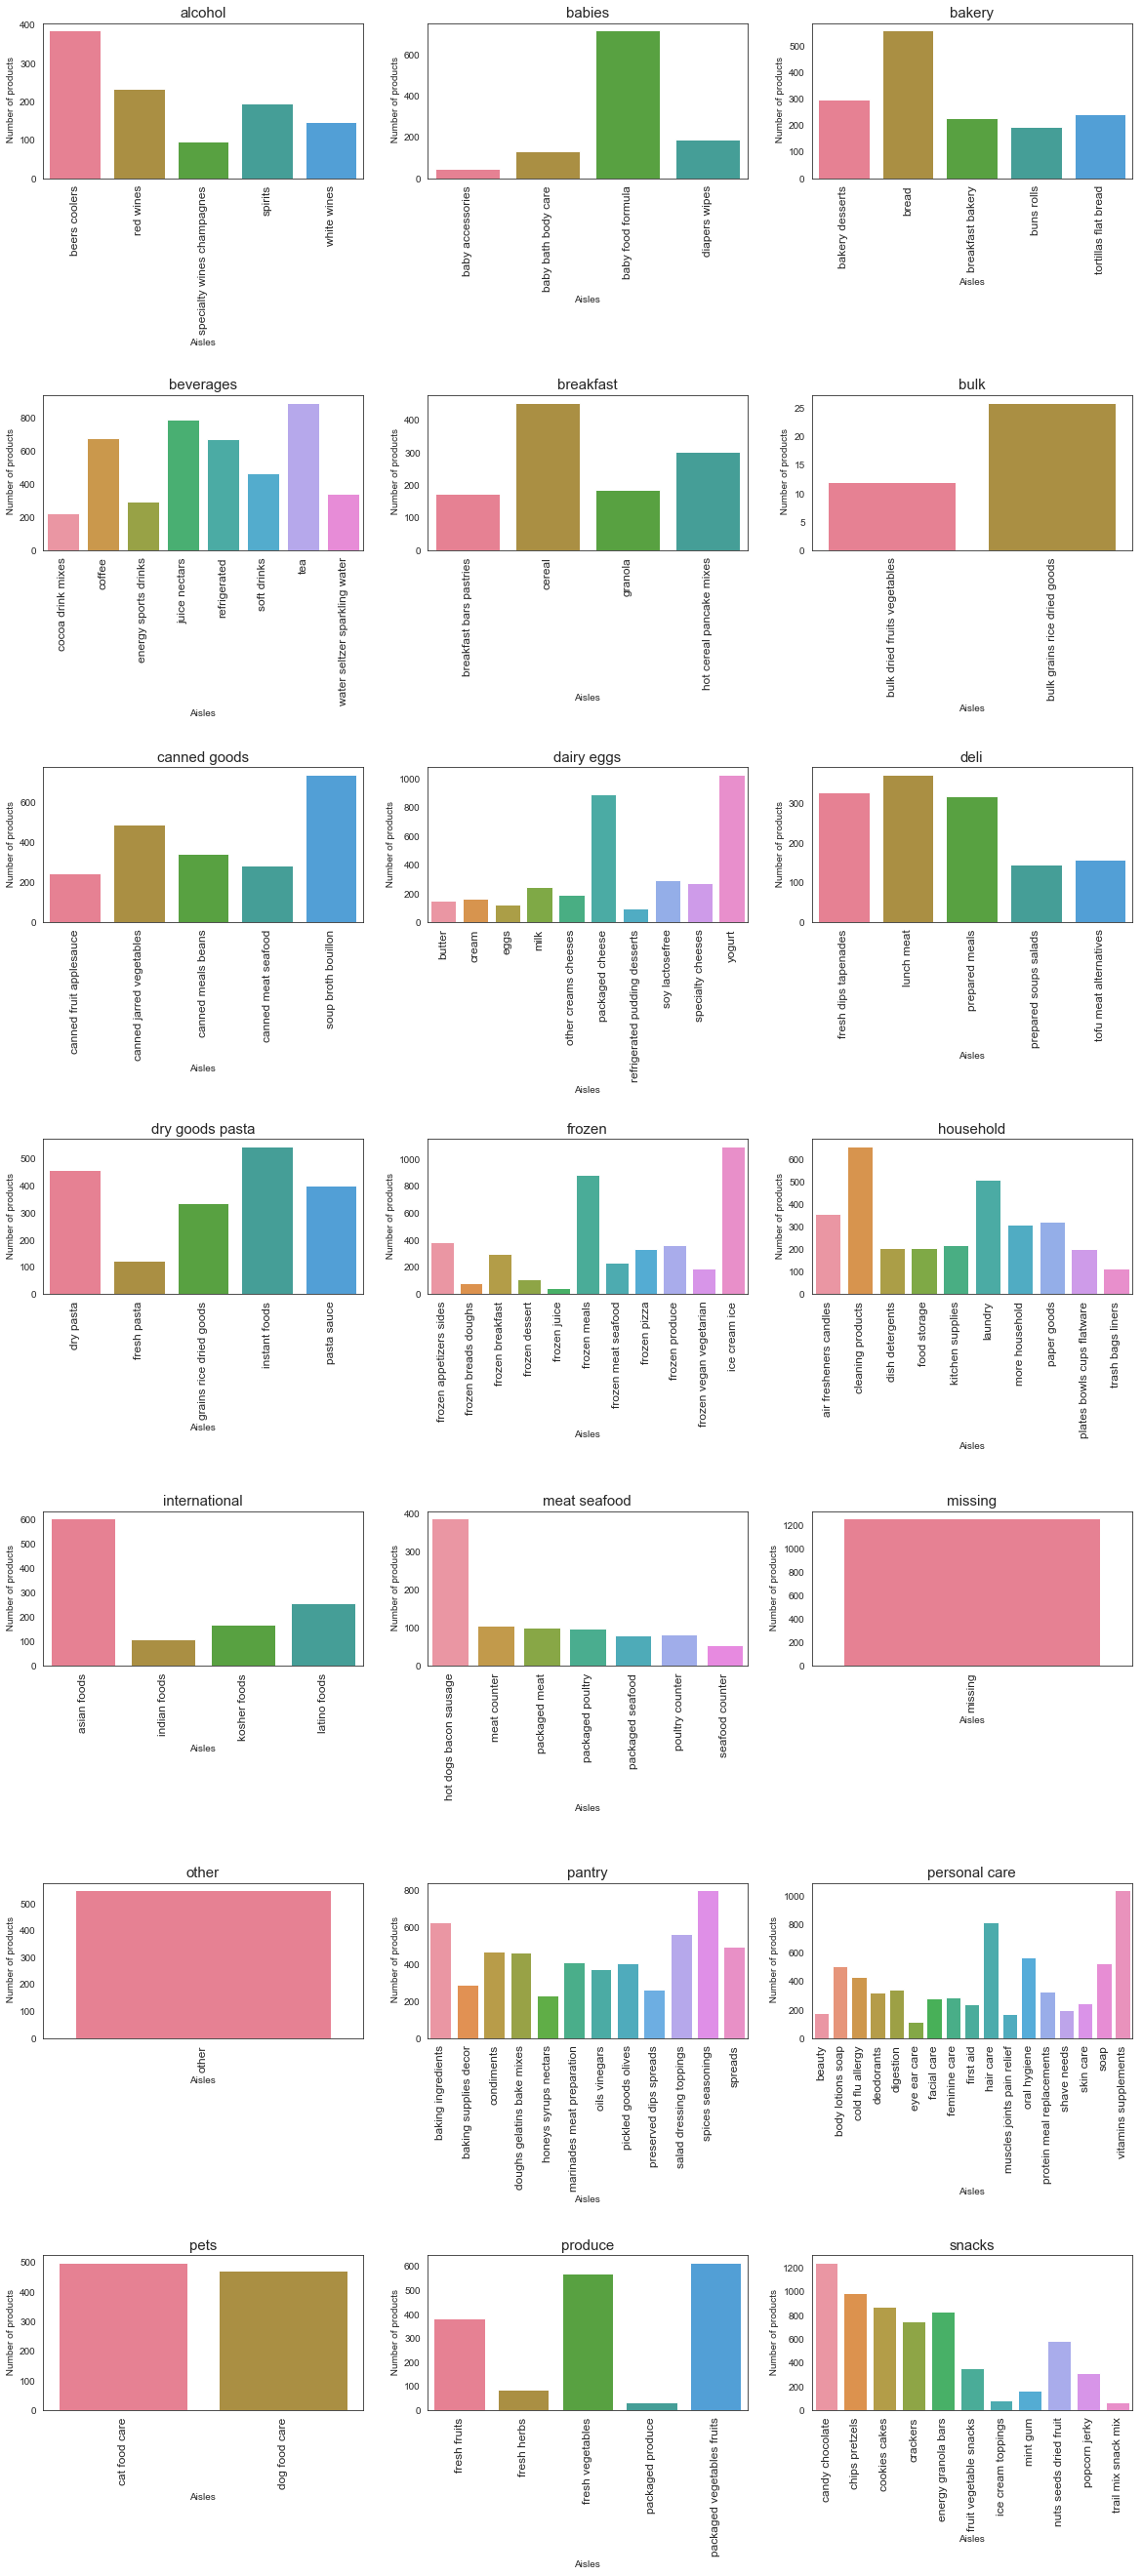

In [215]:
# create df that groups by department and aisle
grouped = grouped.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()

# sort values within df
# grouped.sort_values(by='Total_products', ascending=False, inplace=True)

# plot the data
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)
    
    

### Aisles by Order Volume

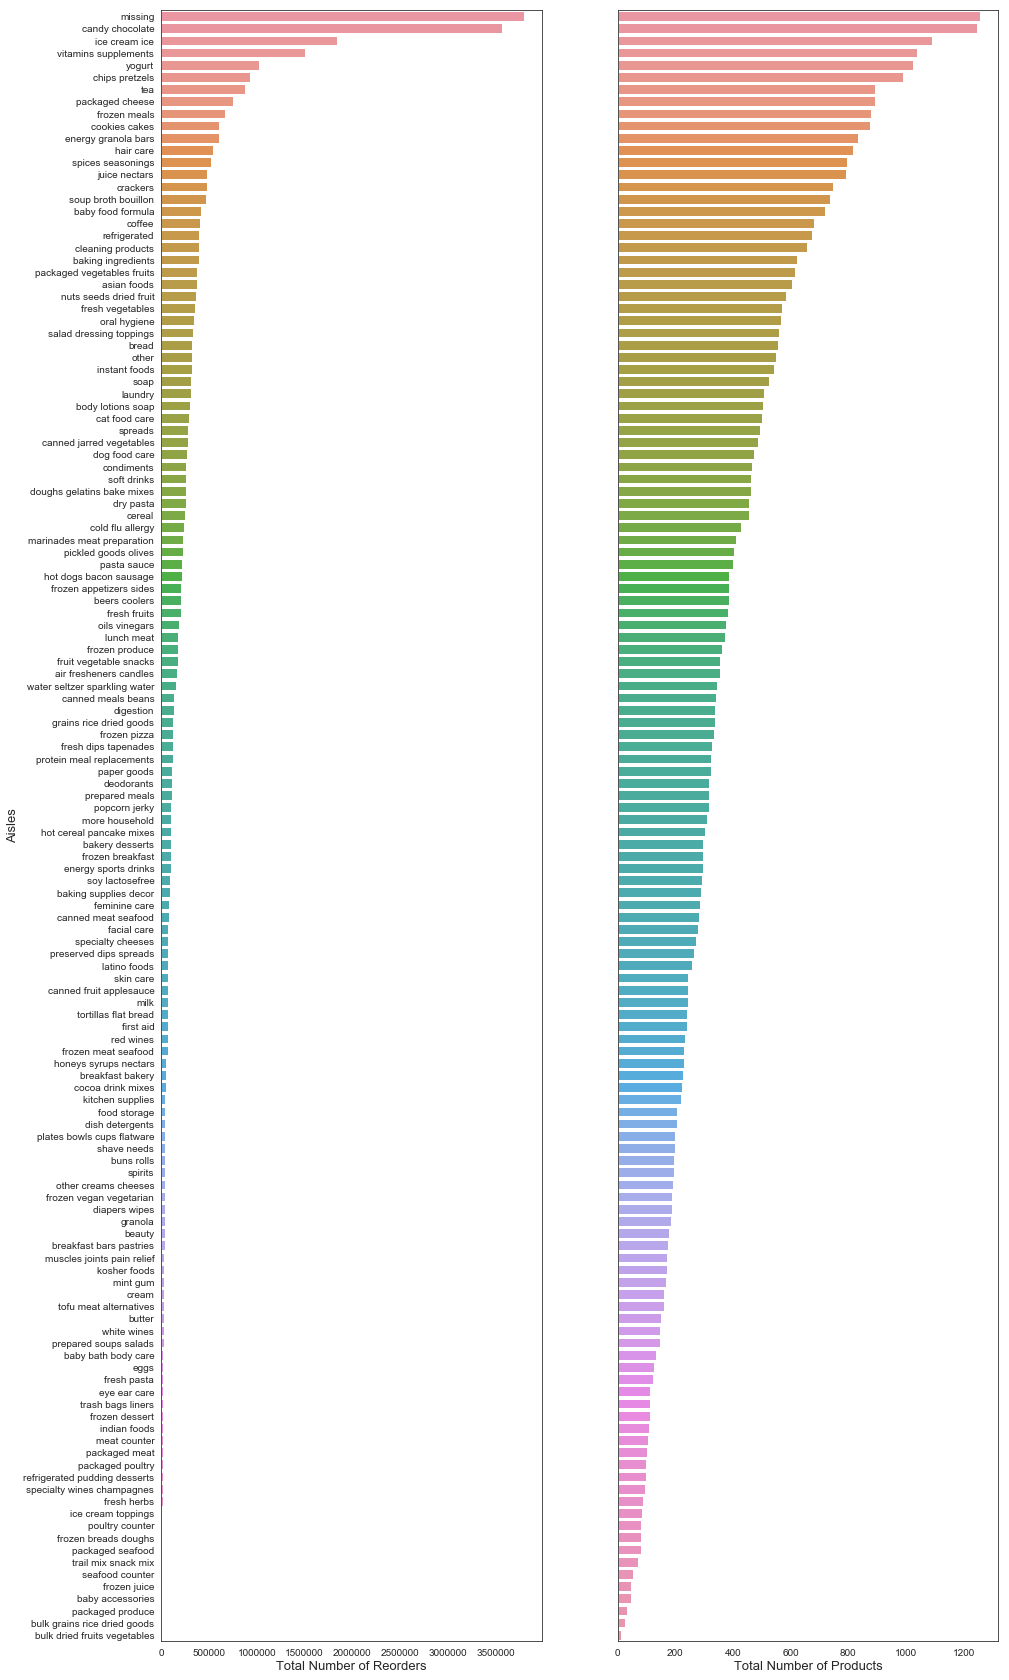

In [222]:
# create new df with departments only by count of reorders
aisles_reorders = grouped.groupby(['aisle']).sum()['reorder_total'].sort_values(ascending=False)

# create new df with departments only by count of products
aisles_products = grouped.groupby(['aisle']).count()['product_id'].sort_values(ascending=False)

# plot data
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 30))
plt.xticks(rotation='horizontal')
sns.barplot(aisles_reorders.values, aisles_reorders.index, ax=ax1)
sns.barplot(aisles_products.values, aisles_products.index, ax=ax2)
ax1.set_xlabel('Total Number of Reorders', fontsize=13)
ax1.set_ylabel('Aisles', fontsize=13)
ax2.set_xlabel('Total Number of Products', fontsize=13)
ax2.set_ylabel(' ')
plt.show()

Missing and Candy Chocolate are the top 2 aisles. We should explore the missing aisle more. 

### The "Missing" Aisle

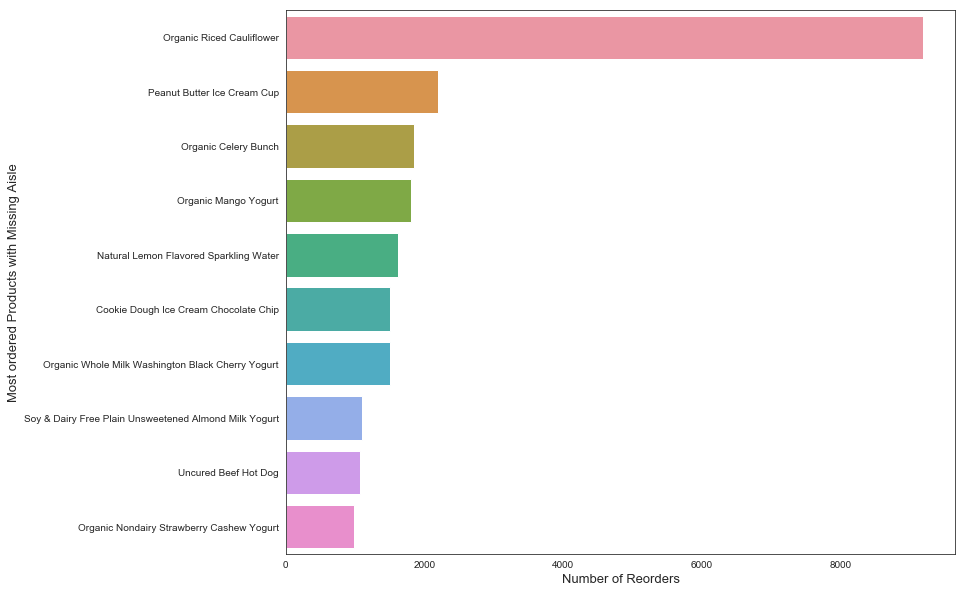

In [239]:
# create DF with missing aisle only
missing_aisle = grouped.loc[grouped['aisle'] == 'missing']

# find top products within that aisle
missing_aisle = missing_aisle.groupby(['product_name']).sum()['reorder_total'].sort_values(ascending=False)

# create top 10 df
missing_aisle_10 = missing_aisle[:10]

# plot the top 20 items
sns.set_style('white')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(missing_aisle_10.values, missing_aisle_10.index)
plt.xlabel('Number of Reorders', fontsize=13)
plt.ylabel('Most ordered Products with Missing Aisle', fontsize=13)
plt.show()

It's interesting that these items are not categorized in an aisle. None of these items will appear in the top 10 products list, however "Organic Riced Cauliflower" may appear withon the top 50 items. 

### Days Since Reorder = 0

In [6]:
# merge all the dfs into a single df
days_df = pd.merge(all_orders, orders, how='left', on='order_id')
days_df = pd.merge(days_df, products, how='left', on='product_id')
days_df = pd.merge(days_df, aisles, how='left', on='aisle_id')
days_df = pd.merge(days_df, departments, how='left', on='department_id')

In [37]:
# pull out the data where the days_since_prior_order column = 0
day_0 = days_df[days_df['days_since_prior_order'] == 0]
day_0.head(20)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
216,24,40078,1,0,193635,prior,19,0,14,0.0,Strawberry Lemonade Frozen Pops,37,1,ice cream ice,frozen
217,24,9065,2,0,193635,prior,19,0,14,0.0,Mint Chocolate Cookie Ice Cream,37,1,ice cream ice,frozen
218,24,46175,3,0,193635,prior,19,0,14,0.0,Half Baked® Ice Cream,37,1,ice cream ice,frozen
359,45,16349,1,1,37913,prior,55,1,14,0.0,Organic Yams,83,4,fresh vegetables,produce
602,73,28413,1,0,152590,prior,13,0,12,0.0,Bunny-Luv Organic Carrots,83,4,fresh vegetables,produce
603,73,24125,2,1,152590,prior,13,0,12,0.0,Olive Bread,112,3,bread,bakery
604,73,11759,3,1,152590,prior,13,0,12,0.0,Organic Simply Naked Pita Chips,107,19,chips pretzels,snacks
605,73,21903,4,1,152590,prior,13,0,12,0.0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
1042,116,27104,1,1,119087,prior,25,6,18,0.0,Fresh Cauliflower,83,4,fresh vegetables,produce
1043,116,42342,2,1,119087,prior,25,6,18,0.0,Roasted Turkey Breast,96,20,lunch meat,deli


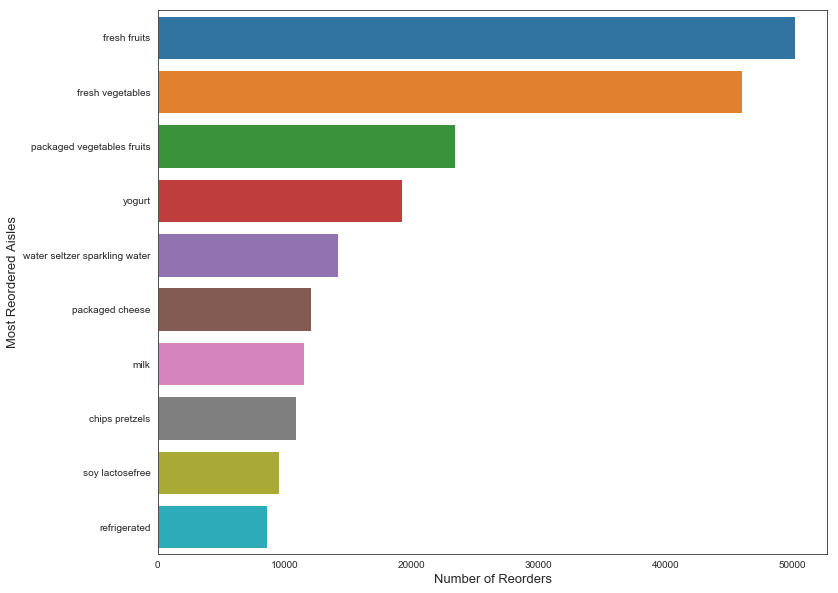

In [32]:
# group by product_id, find find values for reordered, create column that counts the total reorders
aisle_day0 = day_0.groupby("aisle")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()

# sort values, limit to 10 values
aisle_day0 = aisle_day0.sort_values(by='Total_reorders', ascending=False)[:10]

# plot top 10 items
sns.set_style('white')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(aisle_day0.Total_reorders, aisle_day0.aisle)
plt.xlabel('Number of Reorders', fontsize=13)
plt.ylabel('Most Reordered Aisles', fontsize=13)
plt.show()

Fresh fruits, vegetables, and packages fruits & vegetables seem to be the top 3 aisles in the 0 days since reorder. This could mean that people are forgetting items in their origin orders and then placing a second order shortly after. It could also mean that there in incorrect data in the dataset.  

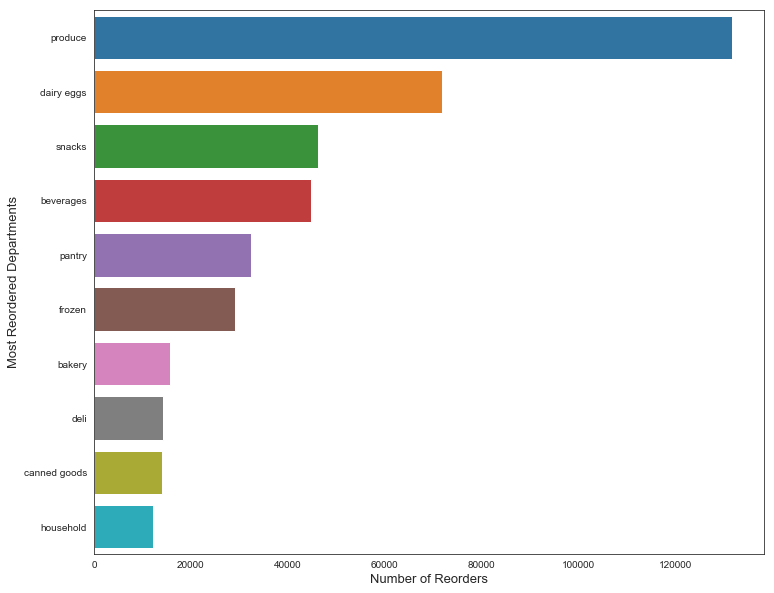

In [35]:
# group by product_id, find find values for reordered, create column that counts the total reorders
department_day0 = day_0.groupby("department")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()

# sort values, limit to 10 values
department_day0 = department_day0.sort_values(by='Total_reorders', ascending=False)[:10]

# plot top 10 items
sns.set_style('white')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(department_day0.Total_reorders, department_day0.department)
plt.xlabel('Number of Reorders', fontsize=13)
plt.ylabel('Most Reordered Departments', fontsize=13)
plt.show()

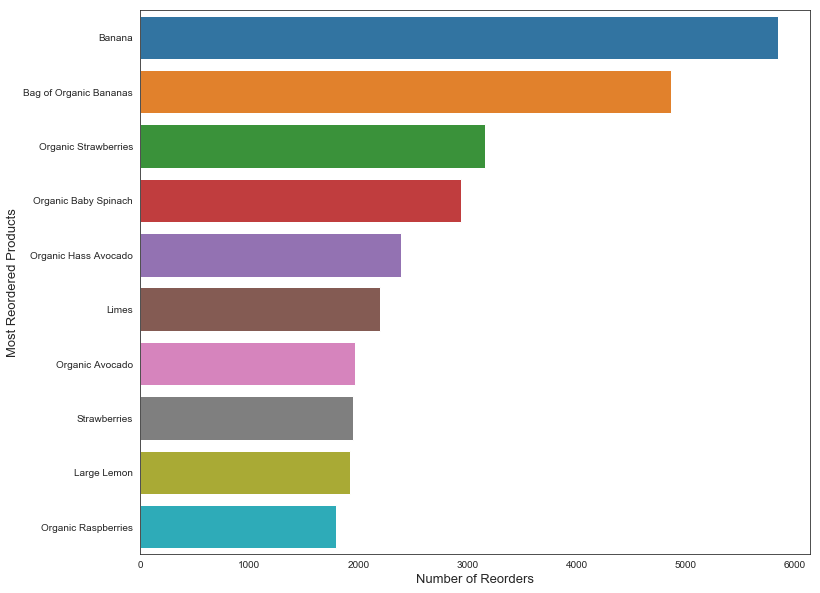

In [40]:
# group by product_id, find find values for reordered, create column that counts the total reorders
product_day0 = day_0.groupby("product_name")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()

# sort values, limit to 10 values
product_day0 = product_day0.sort_values(by='Total_reorders', ascending=False)[:10]

# plot top 10 items
sns.set_style('white')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(product_day0.Total_reorders, product_day0.product_name)
plt.xlabel('Number of Reorders', fontsize=13)
plt.ylabel('Most Reordered Products', fontsize=13)
plt.show()

Interesting.. Even 0 days since reorder Bananas are still the #1 product. Probably need to look into the data more and figure out what's going on here. 

### Looking at the DOW & Total Orders

In [77]:
# create dfs for each day of the week
dow_df0 = df1.loc[df1['order_dow'] == 0].drop(['order_dow'], axis=1)
dow_df1 = df1.loc[df1['order_dow'] == 1].drop(['order_dow'], axis=1)
dow_df2 = df1.loc[df1['order_dow'] == 2].drop(['order_dow'], axis=1)
dow_df3 = df1.loc[df1['order_dow'] == 3].drop(['order_dow'], axis=1)
dow_df4 = df1.loc[df1['order_dow'] == 4].drop(['order_dow'], axis=1)
dow_df5 = df1.loc[df1['order_dow'] == 5].drop(['order_dow'], axis=1)
dow_df6 = df1.loc[df1['order_dow'] == 6].drop(['order_dow'], axis=1)

In [85]:
# merge the dfs together to create 1 large df with total sales for each day of the week by department
new_df = pd.merge(dow_df0, dow_df1, how='left', on='department')
new_df = pd.merge(new_df, dow_df2, how='left', on='department')
new_df = pd.merge(new_df, dow_df3, how='left', on='department')
new_df = pd.merge(new_df, dow_df4, how='left', on='department')
new_df = pd.merge(new_df, dow_df5, how='left', on='department')
new_df = pd.merge(new_df, dow_df6, how='left', on='department')

new_df.columns = (['Department', 'TotalSales_Day0', 'TotalSales_Day1', 'TotalSales_Day2', 'TotalSales_Day3', 'TotalSales_Day4', \
               'TotalSales_Day5', 'TotalSales_Day6'])


In [87]:
new_df

,Department,TotalSales_Day0,TotalSales_Day1,TotalSales_Day2,TotalSales_Day3,TotalSales_Day4,TotalSales_Day5,TotalSales_Day6
0,alcohol,332,630,640,762,986,922,431
1,babies,747,690,634,536,474,529,594
2,bakery,2322,2922,2153,2084,2231,2215,1831
3,beverages,5116,8670,6746,6357,6429,6862,4580
4,breakfast,1277,2116,1535,1352,1338,1574,998
5,bulk,81,126,94,89,104,114,82
6,canned goods,2660,2502,1828,1686,1670,1849,1920
7,dairy eggs,10270,13334,10029,9431,9486,11185,8004
8,deli,2173,2625,1967,1934,1990,2042,1600
9,dry goods pasta,1977,1899,1377,1338,1232,1323,1377


We can see spikes in alcohol sales on days 3, 4, and 5. We can also see large drops in alcohol sales on days 6 and 0. Alcohol sales tend to increase on Thursday, Friday, & Saturday, so we could speculate that these are the days. However, we do not have enough information to make a conclusion. 

### Organic vs Non-Organic Products

In [9]:
# create new df that looks for organic in the product name
products_new = products.copy()
products_new['organic'] = products.product_name.str.contains('Organic').astype(np.int8)
products_new.head()

,product_id,product_name,aisle_id,department_id,organic
0,1,Chocolate Sandwich Cookies,61,19,0
1,2,All-Seasons Salt,104,13,0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0
4,5,Green Chile Anytime Sauce,5,13,0


In [12]:
# create df that shows total # of products and percentage of products with organic and non-organic in the name
products_new1 = products_new.groupby("organic")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
products_new1['Ratios'] = products_new1["Total_products"].apply(lambda x: x /products_new1['Total_products'].sum())
products_new1

,organic,Total_products,Ratios
0,0,44653,0.898668
1,1,5035,0.101332


About 90% of the products are non-organic, while 10% are orgnanic products. 

In [15]:
# let's look at the reorders for organic & non-organic products
# merge dfs to create large df
organic_df = pd.merge(all_orders, products_new, how='left', on='product_id')
organic_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic
0,2,33120,1,1,Organic Egg Whites,86,16,1
1,2,28985,2,1,Michigan Organic Kale,83,4,1
2,2,9327,3,0,Garlic Powder,104,13,0
3,2,45918,4,1,Coconut Butter,19,13,0
4,2,30035,5,0,Natural Sweetener,17,13,0


In [18]:
# order by organic & reordered to find the percentage of products reordered 
organic1 = organic_df.groupby(["organic", "reordered"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
organic1['Ratios'] = organic1["Total_products"].apply(lambda x: x /organic1['Total_products'].sum())
organic1

,organic,reordered,Total_products,Ratios
0,0,0,9978458,0.295054
1,0,1,13184660,0.389858
2,1,0,3885288,0.114884
3,1,1,6770700,0.200203


Not Organic & Not Reordered: 0.4307907942272711
Not Organic &     Reordered: 0.5692092057727288
    Organic & Not Reordered: 0.3646107709580754
    Organic &     Reordered: 0.6353892290419246
    
Interesting! Organic products tend to be reordered more frequently than non-organic products. 

### Looking at General Reorders

In [11]:
df_reordered = all_orders.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
df_reordered['Ratios'] = df_reordered["Total_products"].apply(lambda x: x /df_reordered['Total_products'].sum())
df_reordered

,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


Of all the products in the DF (organic and non-organic), 59% of the products are reordered and 41% of the products are not reordered